In [1]:
import tweepy
import json
import mysql.connector
from mysql.connector import Error
import os
from dotenv import load_dotenv
from dateutil import parser
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
load_dotenv('E:\Data Analytics Practice\.env')

#adding key and token for twitter API using environmental variables
consumer_key = os.environ['CONSUMER_KEY']
consumer_secret = os.environ['CONSUMER_SECRET']
access_token = os.environ['ACCESS_TOKEN']
access_token_secret = os.environ['ACCESS_TOKEN_SECRET']
password = os.environ['PASSWORD']

#creating list of stopwords
stopword_list = stopwords.words('english')

In [3]:
#function to insert tweets into database.
def connect(username, created_at, tweet_text, user_location, user_followers_count, user_friends_count, retweet_count, favorite_count, sentiment):
    """connect to MYSQL database and insert record(tweets)"""
    try:
        con = mysql.connector.connect(host='localhost', 
        database='twitterdb',user='test_user', password= password, charset='utf8', auth_plugin='mysql_native_password')

        if con.is_connected():
            cursor = con.cursor()
            query = "INSERT INTO tweets_data(username, tweet_text, created_at, user_followers_count, user_location, user_friends_count, favorite_count, retweet_count, sentiment) VALUES (%s, %s, %s, %s, %s, %s, %s, %s,%s)"
            cursor.execute(query, (username, tweet_text, created_at, user_followers_count, user_location, user_friends_count, favorite_count, retweet_count, sentiment))
            con.commit()

    except Error as e:
        print(e)

    cursor.close()
    con.close()
    return


In [4]:
#Inherited StreamListener class and redefined(override) its class methods.
class Streamlistener(tweepy.StreamListener):
    def on_connect(self):
        print('Connected you Twitter API!')

    def on_error(self):
        if status_code != 200:
            print("error found")
            return False
            
    def on_data(self,data):
        try:
            #convert json string into python dictionary
            raw_data = json.loads(data)
            if 'text' in raw_data:
                username = raw_data['user']['screen_name']
                created_at = parser.parse(raw_data['created_at'])
                tweet_text = clean_tweet(raw_data['text'])
                location = raw_data['user']['location']
                followers_count = raw_data['user']['followers_count']
                friends_count = raw_data['user']['friends_count']
                retweet_count = raw_data['retweet_count']
                favorite_count = raw_data['favorite_count']
                sentiment = get_tweet_sentiment(tweet_text)
                connect(username, created_at, tweet_text, location, followers_count, friends_count, retweet_count, favorite_count, sentiment)
                print("tweet collected at: {} ".format(str(created_at)))
        except Error as e:
            print("Error ",e)
                            
#function to clean tweet text i.e removing '@', "#", weblinks etc.               
def clean_tweet(tweet):
    tweet_text = tweet.lower()
    tweet_text = re.sub("(@[A-Za-z0-9_]+)| (#[A-Za-z0-9_]+)","", tweet_text)
    tweet_link = re.sub("(https\S+) |(www.\S+)","", tweet_text)
    tweet_link = re.sub(r"http\S+","",tweet_text)
    tweet_link = re.sub(r"www.\S+","",tweet_link)
    tweet_punch = re.sub("([()!?])|(\[.*?\])","", tweet_link)
    tweet_text = re.sub("[^a-z0-9]"," ", tweet_punch)
    tweet_text_token = tweet_text.split()
    token_temp = [word for word in tweet_text_token if not word in stopword_list]
    tweet_text = " ".join(word for word in token_temp)
    # print(token_temp)
    # print(tweet_text)
    return tweet_text

#function to get sentiment
def get_tweet_sentiment(tweet):
    """TextBlob class is used to find polarity of text"""
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"


In [ ]:
if __name__ == "__main__":
    #Authentication of Twitter API
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)

    listener = Streamlistener()
    stream = tweepy.Stream(auth, listener=listener)
    #define 'hashtags' or query text (to fetch tweets of relevant input)
    track = ['farmlaws, farmers']
    stream.filter(track=track, languages=['en'])    

In [6]:
#fetching data from database for further analysis
try:
        con_db = mysql.connector.connect(host='localhost', 
        database='twitterdb',user='test_user', password= password, charset='utf8', auth_plugin='mysql_native_password')
        tweets_list = []
        if con_db.is_connected():
            print("connected")
            cursor_db = con_db.cursor()
            query = "select * from twitterdb.tweets_data;"
            cursor_db.execute(query)
            results = cursor_db.fetchall()
            ptweets = [tweet for tweet in results if tweet[9] == 'positive']
            ntweets = [tweet for tweet in results if tweet[9] == 'negative']
            neu_tweets = [tweet for tweet in results if tweet[9] == 'neutral']
            for x in results:
                tweets_list.append(x[2])
except:
    print("error")

cursor_db.close()
con_db.close()
print("p", len(ptweets))
print("ne", len(ntweets))
print("neu", len(neu_tweets))


connected
p 671
ne 318
neu 947


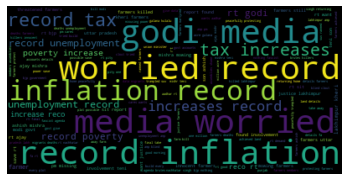

In [7]:
long_text = ""
for x in tweets_list:
    long_text = long_text + "," + x


#create wordcloud
wordcloud_2 = WordCloud(max_font_size=40).generate(long_text)
plt.figure()
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.show()




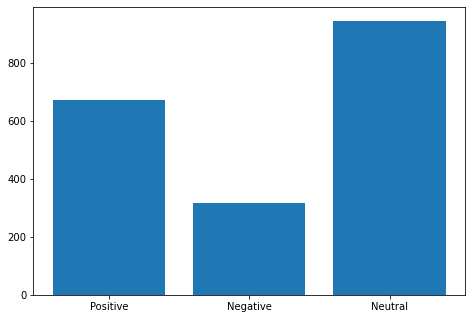

In [9]:
#create bar graph showing category of tweets
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
tweet_category = ["Positive", "Negative", "Neutral"]
tweet_category_data = [len(ptweets), len(ntweets), len(neu_tweets)]
ax.bar(tweet_category, tweet_category_data)
plt.show()